In [1]:
#hide
from fastbook import *

In [6]:
from fastai.vision.all import *

In [2]:
path = Path('data/face_age')

In [3]:
path = Path('/ds/data/face_age')

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#99) [Path('046'),Path('035'),Path('012'),Path('017'),Path('008'),Path('059'),Path('064'),Path('049'),Path('076'),Path('025')...]

In [7]:
(path/"016").ls()

(#212) [Path('016/4559.png'),Path('016/3694.png'),Path('016/7290.png'),Path('016/5878.png'),Path('016/3197.png'),Path('016/4076.png'),Path('016/5791.png'),Path('016/8135.png'),Path('016/9750.png'),Path('016/4780.png')...]

In [7]:
fname = (path/"016").ls()[0]
fname

Path('016/1067.png')

Init signature:
DataBlock(
    blocks=None,
    dl_type=None,
    getters=None,
    n_inp=None,
    item_tfms=None,
    batch_tfms=None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Source:        
class DataBlock():
    "Generic container to quickly build `Datasets` and `DataLoaders`"
    get_x=get_items=splitter=get_y = None
    blocks,dl_type = (TransformBlock,TransformBlock),TfmdDL
    _methods = 'get_items splitter get_y get_x'.split()
    _msg = "If you wanted to compose several transforms in your getter don't forget to wrap them in a `Pipeline`."
    def __init__(self, blocks=None, dl_type=None, getters=None, n_inp=None, item_tfms=None, batch_tfms=None, **kwargs):
        blocks = L(self.blocks if blocks is None else blocks)
        blocks = L(b() if callable(b) else b for b in blocks)
        self.type_tfms = blocks.attrgot('type_tfms', L())
        self.default_item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
        self.default_

In [23]:
re.findall(r'(.+)_\d+.png$', fname.name)

[]

This regular expression plucks out all the characters leading up to the last underscore character, as long as the subsequence characters are numerical digits and then the JPEG file extension.

Now that we confirmed the regular expression works for the example, let's use it to label the whole dataset. fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the `RegexLabeller` class. In this example we use the data block API we saw in <<chapter_production>> (in fact, we nearly always use the data block API—it's so much more flexible than the simple factory methods we saw in <<chapter_intro>>):

In [40]:

def parent_int_label(o):
    "Label `item` with the parent folder name."
    return int(parent_label(o))

pets = DataBlock(blocks = (ImageBlock, RegressionBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_int_label,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75,max_warp=0))
dls = pets.dataloaders(path)

One important piece of this `DataBlock` call that we haven't seen before is in these two lines:

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

These lines implement a fastai data augmentation strategy which we call *presizing*. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

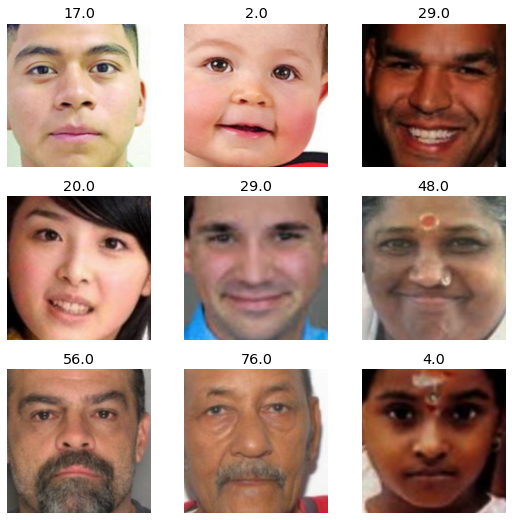

In [41]:
dls.show_batch()

## Presizing

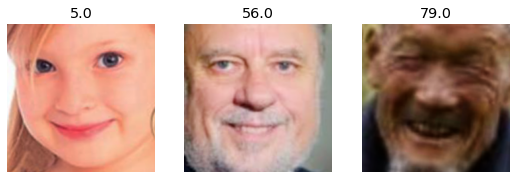

In [42]:
dls.show_batch(nrows=1, ncols=3)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=6.309573450380412e-07)

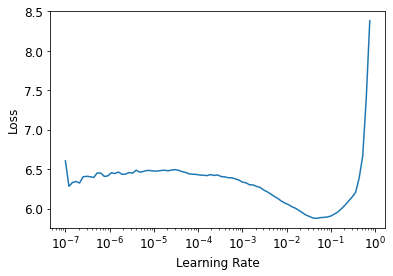

In [43]:
learn = cnn_learner(pets1.dataloaders(path), resnet18)
learn.lr_find()

In [44]:
learn = cnn_learner(dls, resnet18)
learn.fine_tune(6,0.004786301031708717)

epoch,train_loss,valid_loss,time
0,163.619553,109.749863,02:08
1,117.158615,82.200714,02:08
2,88.403114,76.453400,02:08
3,71.940353,65.386681,02:07
4,58.332840,57.342274,02:08
5,56.354721,54.090282,02:08


In [20]:
learn.export('resnet34-5cycles-lr005')

In [21]:
learn = cnn_learner(pets1.dataloaders(path), resnet18)
learn.load('resnet34-5cycles-lr005')

In [46]:
preds,_ = learn.get_preds(dls.valid)
preds[0]

TypeError: list indices must be integers or slices, not TfmdDL

The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:

In [ ]:
#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.99664,0.00336017,1,3,0.00336017
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


Looking at this table, you can see that the final column can be calculated by taking the `targ` and `idx` columns as indices into the two-column matrix containing the `3` and `7` columns. That's what `sm_acts[idx, targ]` is actually doing.

The really interesting thing here is that this actually works just as well with more than two columns. To see this, consider what would happen if we added an activation column for every digit (0 through 9), and then `targ` contained a number from 0 to 9. As long as the activation columns sum to 1 (as they will, if we use softmax), then we'll have a loss function that shows how well we're predicting each digit.

We're only picking the loss from the column containing the correct label. We don't need to consider the other columns, because by the definition of softmax, they add up to 1 minus the activation corresponding to the correct label. Therefore, making the activation for the correct label as high as possible must mean we're also decreasing the activations of the remaining columns.

PyTorch provides a function that does exactly the same thing as `sm_acts[range(n), targ]` (except it takes the negative, because when applying the log afterward, we will have negative numbers), called `nll_loss` (*NLL* stands for *negative log likelihood*):

In [ ]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Ragdoll', 'Birman', 8),
 ('Siamese', 'Birman', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]

Since we are not pet breed experts, it is hard for us to know whether these category errors reflect actual difficulties in recognizing breeds. So again, we turn to Google. A little bit of Googling tells us that the most common category errors shown here are actually breed differences that even expert breeders sometimes disagree about. So this gives us some comfort that we are on the right track.

We seem to have a good baseline. What can we do now to make it even better?

## Improving Our Model

In [ ]:
learn.fine_tune??

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.188042,0.355024,0.102842,00:20
1,0.534234,0.302453,0.094723,00:20
2,0.325031,0.222268,0.074425,00:20


Then we'll unfreeze the model:

In [36]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=2.75422871709452e-06)

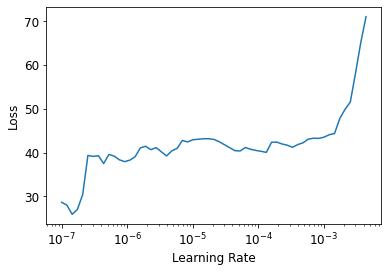

In [37]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

Let's train at a suitable learning rate:

In [38]:
learn.fit_one_cycle(6, lr_max=9.12010818865383e-08)

This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

### Discriminative Learning Rates

Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

In addition, do you remember the images we saw in <<chapter_intro>>, showing what each layer learns? The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like "eye" and "sunset," which might not be useful in your task at all (maybe you're classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai's default approach is to use discriminative learning rates. This was originally developed in the ULMFiT approach to NLP transfer learning that we will introduce in <<chapter_nlp>>. Like many good ideas in deep learning, it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). The idea is based on insights developed by [Jason Yosinski](https://arxiv.org/abs/1411.1792), who showed in 2014 that with transfer learning different layers of a neural network should train at different speeds, as seen in <<yosinski>>.

<img alt="Impact of different layers and training methods on transfer learning (Yosinski)" width="680" caption="Impact of different layers and training methods on transfer learning (courtesy of Jason Yosinski et al.)" id="yosinski" src="images/att_00039.png">

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the *lowest* layer of our net to a learning rate of 1e-6; the other layers will scale up to 1e-4. Let's train for a while and see what happens:

In [47]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

Now the fine-tuning is working great!

fastai can show us a graph of the training and validation loss:

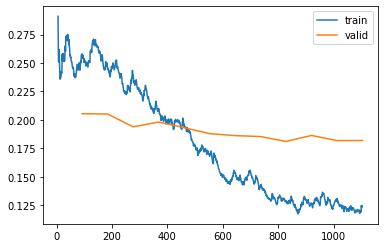

In [ ]:
learn.recorder.plot_loss()

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does *not* mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

Another decision you have to make when training the model is for how long to train for. We'll consider that next.

### Selecting the Number of Epochs

Often you will find that you are limited by time, rather than generalization and accuracy, when choosing how many epochs to train for. So your first approach to training should be to simply pick a number of epochs that will train in the amount of time that you are happy to wait for. Then look at the training and validation loss plots, as shown above, and in particular your metrics, and if you see that they are still getting better even in your final epochs, then you know that you have not trained for too long.

On the other hand, you may well see that the metrics you have chosen are really getting worse at the end of training. Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics. Your validation loss will first get worse during training because the model gets overconfident, and only later will get worse because it is incorrectly memorizing the data. We only care in practice about the latter issue. Remember, our loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice.

Before the days of 1cycle training it was very common to save the model at the end of each epoch, and then select whichever model had the best accuracy out of all of the models saved in each epoch. This is known as *early stopping*. However, this is very unlikely to give you the best answer, because those epochs in the middle occur before the learning rate has had a chance to reach the small values, where it can really find the best result. Therefore, if you find that you have overfit, what you should actually do is retrain your model from scratch, and this time select a total number of epochs based on where your previous best results were found.

If you have the time to train for more epochs, you may want to instead use that time to train more parameters—that is, use a deeper architecture.

### Deeper Architectures

In general, a model with more parameters can model your data more accurately. (There are lots and lots of caveats to this generalization, and it depends on the specifics of the architectures you are using, but it is a reasonable rule of thumb for now.) For most of the architectures that we will be seeing in this book, you can create larger versions of them by simply adding more layers. However, since we want to use pretrained models, we need to make sure that we choose a number of layers that have already been pretrained for us.

This is why, in practice, architectures tend to come in a small number of variants. For instance, the ResNet architecture that we are using in this chapter comes in variants with 18, 34, 50, 101, and 152 layer, pretrained on ImageNet. A larger (more layers and parameters; sometimes described as the "capacity" of a model) version of a ResNet will always be able to give us a better training loss, but it can suffer more from overfitting, because it has more parameters to overfit with.

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.

However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an *out-of-memory error*. This happens when you try to fit too much inside your GPU and looks like:

```
Cuda runtime error: out of memory
```

You may have to restart your notebook when this happens. The way to solve it is to use a smaller batch size, which means passing smaller groups of images at any given time through your model. You can pass the batch size you want to the call creating your `DataLoaders` with `bs=`.

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is *mixed-precision training*. This refers to using less-precise numbers (*half-precision floating point*, also called *fp16*) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called *tensor cores* that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add `to_fp16()` after your `Learner` creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision: